# Portfolio Optimisation for Net Zero Emission Portfolio

In [44]:
import refinitiv.data as rd
import refinitiv.data.eikon as ek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
import pickle

import warnings
warnings.filterwarnings("ignore")

In [45]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x16e284610 {name='workspace'}>

### Fetching and Processing Financial Data with Jupyter Notebooks

1. **StopExecution Class**: A custom exception class `StopExecution` is defined. This class overrides the `_render_traceback_` method to prevent Jupyter from printing the traceback when the exception is raised.

2. **File Existence Check**: The code checks if a file named 'portfolio.csv' exists in the current directory.

    - If the file exists, it is read into a DataFrame `portfolio_df`.

    - If the file does not exist, the code proceeds to execute a Jupyter notebook to fetch the data.

3. **Executing a Jupyter Notebook**: If 'portfolio.csv' does not exist, the code executes a Jupyter notebook named 'data.ipynb' to fetch the data.

    - The notebook is loaded using the `nbformat` library.

    - The `ExecutePreprocessor` class from the `nbconvert` library is used to execute the notebook. A timeout of 1200 seconds is set, and the kernel used for execution is 'python3'.

    - If an error occurs during the execution of the notebook, the error message is printed and the error is raised.

    - After the notebook is executed, 'portfolio.csv' should exist in the directory. The file is read into the `portfolio_df` DataFrame.

4. **Data Output**: Finally, the first five rows of the `portfolio_df` DataFrame are printed to inspect the fetched data.

In [46]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Check if the file 'portfolio.csv' exists in the directory
if os.path.isfile('portfolio.csv'):
    print('portfolio.csv exists in the directory.')
    # Read the existing file
    portfolio_df = pd.read_csv('portfolio.csv', index_col=0)
else:
    print('portfolio.csv does not exist in the directory. Executing data.ipynb to fetch data...')
    
    # Load the notebook
    with open("data.ipynb") as f:
        nb = nbformat.read(f, as_version=4)

    # Execute the notebook
    ep = ExecutePreprocessor(timeout=1200, kernel_name='python3')
    try:
        ep.preprocess(nb, {'metadata': {'path': './'}})
        print("data.ipynb executed successfully.")
    except Exception as e:
        print(f"Error executing the notebook: {e}")
        raise

    # Read the portfolio data after executing the notebook
    portfolio_df = pd.read_csv('portfolio.csv', index_col=0)

# Output the final portfolio DataFrame to inspect the result
portfolio_df.head(5)

portfolio.csv exists in the directory.


,AAL.L,ABF.L,AHT.L,ANTO.L,AV.L,AZN.L,BAES.L,BARC.L,BATS.L,BDEV.L,...,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VOD.L,WEIR.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,996.961318,327.615390,154.593367,86.037092,920.324120,2392.339763,408.50,375.588870,332.25,165.053794,...,625.338004,181.484681,88.529409,1013.333232,165.428281,529.350796,295.186056,231.0,970.0,538.219010
2000-01-05,1005.684729,332.799959,153.229308,86.037092,893.154057,2346.502026,401.25,366.592729,335.50,163.611016,...,634.263903,184.480301,92.057755,1019.999898,165.428281,537.034921,280.914974,237.5,875.0,536.904143
2000-01-06,1030.359522,364.401142,151.410563,86.334798,884.756038,2341.625671,404.75,352.873615,328.25,163.033905,...,682.568770,184.480301,94.303066,1053.333228,165.428281,557.952815,272.402399,249.0,867.5,543.040190
2000-01-07,1066.748610,353.538236,151.410563,86.334798,904.516084,2397.216118,388.25,345.001992,331.25,166.208016,...,706.721203,181.983951,96.548378,1104.444334,165.428281,567.771419,287.674960,244.0,900.0,569.337536
2000-01-10,1077.964425,357.241499,146.863699,86.830975,910.444097,2463.534546,380.25,349.724966,326.75,159.571238,...,699.370463,176.242345,93.340790,1064.444338,165.428281,577.163126,302.196411,243.5,943.5,552.244261


In [47]:
# Check if the file 'top_per_sector.pkl' exists in the directory
if os.path.isfile('top_per_sector.pkl'):
    print('top_per_sector.pkl exists in the directory.')
    # Load the DataFrame from the pickle file
    with open('top_per_sector.pkl', 'rb') as f:
        top_per_sector = pickle.load(f)

top_per_sector.pkl exists in the directory.


# Sharpe Ratio

 Most investors aren't okay with taking on high-levels of risk, so our goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". Well, this can lead you down a rabbit hole because there are many ways to measure risk and some are more appropriate than others depending on the situation at hand. In our case, we will use a very popular metric, the `Sharpe Ratio`. The Sharpe Ratio, is used as a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

# Monte Carlo Simulation for Portfolio Optimization

Monte Carlo simulation is performed below to optimize a financial portfolio. It begins by calculating the log returns of the portfolio data using the formula `log_return = np.log(1 + portfolio_df.pct_change())`. It then sets the parameters for the Monte Carlo simulation, including the number of portfolios to simulate, the risk-free rate, and the number of constituents in each random portfolio. 

Arrays are prepared to store the simulation results, including returns, volatility, Sharpe ratio, ESG score, portfolio weights, and symbols. The ESG scores are converted to a dictionary for easy lookup. The Monte Carlo simulation is then performed. For each portfolio, it randomly selects symbols, generates random portfolio weights, calculates expected returns using the formula `ret_arr[ind] = np.sum((selected_log_return.mean() * weights) * 252)`, volatility using the formula `vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_log_return.cov() * 252, weights)))`, Sharpe ratio using the formula `sharpe_arr[ind] = (ret_arr[ind] - risk_free_rate) / vol_arr[ind]`, and ESG score, and stores these results.

A DataFrame is created to store the simulation results. Weights for the composite score are defined, Sharpe ratios and ESG scores are normalized, and the composite score is calculated using the formula `simulations_df['Composite Score'] = sharpe_weight * simulations_df['Normalized Sharpe'] + esg_weight * simulations_df['Normalized ESG']`. The portfolio with the highest composite score is found and the symbols and weights for the optimal portfolio are extracted. 

A dictionary is created for the optimal portfolio data and converted to a DataFrame. The simulation results are plotted, showing portfolio returns vs. risk, and the optimal portfolio is highlighted. Finally, the optimal portfolio is printed.

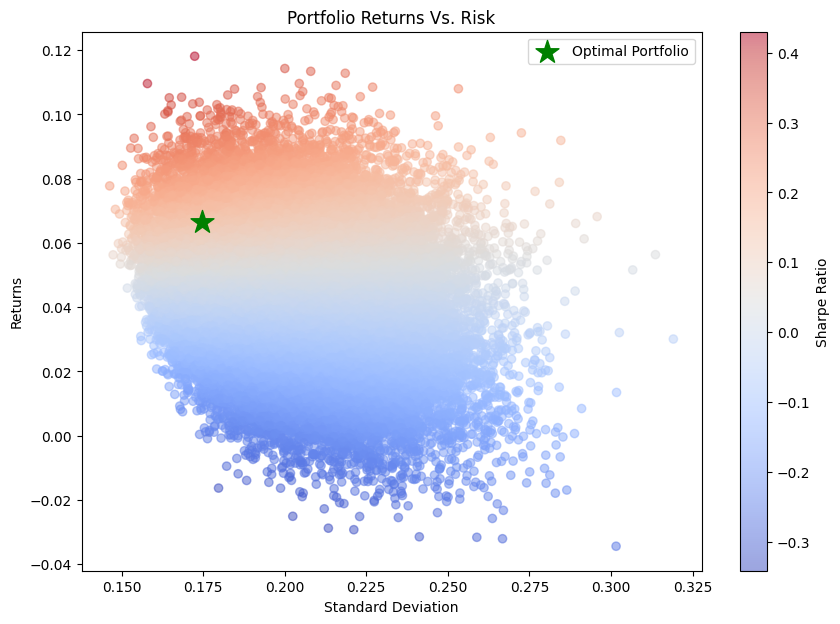

,Returns,Volatility,Sharpe Ratio,ESG Score,MKS.L,AZN.L,STAN.L,SHEL.L,RKT.L,BATS.L,HSBA.L,HWDN.L,UTG.L,ANTO.L
0,0.066441,0.174688,0.128465,87.078918,0.013216,0.208106,0.059996,0.179883,0.168135,0.202565,0.014996,0.030633,0.009927,0.112543


In [48]:
# Calculate the Log of returns
log_return = np.log(1 + portfolio_df.pct_change())

# Monte Carlo Simulation parameters
num_of_portfolios = 50000 # Number of portfolios to simulate
risk_free_rate = 0.044 # UK 10-Year Government Bond Yield
num_of_constituents = 10  # Number of constituents in each random portfolio

# Prepare arrays to store the simulation results
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)
esg_arr = np.zeros(num_of_portfolios)
all_weights = []
all_symbols = []

# Convert ESG scores to a dictionary for easy lookup
esg_scores_dict = top_per_sector.set_index('Instrument')['ESG Score'].to_dict()

# Start the simulations
for ind in range(num_of_portfolios):
    # Randomly select 10 symbols
    selected_symbols = np.random.choice(portfolio_df.columns, num_of_constituents, replace=False)
    
    # Extract data for the selected symbols
    selected_log_return = log_return[selected_symbols]
    
    # Generate random portfolio weights
    weights = np.random.random(num_of_constituents)
    weights /= np.sum(weights)
    
    # Store the weights and symbols
    all_weights.append(weights)
    all_symbols.append(selected_symbols)
    
    # Calculate expected returns and add to returns array
    ret_arr[ind] = np.sum((selected_log_return.mean() * weights) * 252)
    
    # Calculate volatility and add to volatility array
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_log_return.cov() * 252, weights)))
    
    # Calculate Sharpe ratio and add to Sharpe ratio array
    sharpe_arr[ind] = (ret_arr[ind] - risk_free_rate) / vol_arr[ind]
    
    # Extract ESG scores for the selected symbols
    esg_scores = np.array([esg_scores_dict[symbol] for symbol in selected_symbols])
    
    # Calculate ESG score and add to ESG array
    esg_arr[ind] = np.sum(esg_scores * weights)

# Create a DataFrame for the simulation results
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'ESG Score': esg_arr,
    'Symbols': all_symbols,
    'Weights': all_weights
})

# Define weights for the composite score
sharpe_weight = 0.5
esg_weight = 0.5

# Normalize Sharpe ratios and ESG scores
simulations_df['Normalized Sharpe'] = (simulations_df['Sharpe Ratio'] - simulations_df['Sharpe Ratio'].min()) / (simulations_df['Sharpe Ratio'].max() - simulations_df['Sharpe Ratio'].min())
simulations_df['Normalized ESG'] = (simulations_df['ESG Score'] - simulations_df['ESG Score'].min()) / (simulations_df['ESG Score'].max() - simulations_df['ESG Score'].min())

# Calculate the composite score
simulations_df['Composite Score'] = sharpe_weight * simulations_df['Normalized Sharpe'] + esg_weight * simulations_df['Normalized ESG']

# Find the portfolio with the highest composite score
optimal_portfolio = simulations_df.loc[simulations_df['Composite Score'].idxmax()]

# Extract the symbols and weights for the optimal portfolio
optimal_symbols = optimal_portfolio['Symbols']
optimal_weights = optimal_portfolio['Weights']

# Create a dictionary for the optimal portfolio data
optimal_portfolio_data = {
    'Returns': optimal_portfolio['Returns'],
    'Volatility': optimal_portfolio['Volatility'],
    'Sharpe Ratio': optimal_portfolio['Sharpe Ratio'],
    'ESG Score': optimal_portfolio['ESG Score']
}
optimal_portfolio_data.update({optimal_symbols[i]: optimal_weights[i] for i in range(num_of_constituents)})

# Convert the dictionary to a DataFrame
optimal_portfolio_df = pd.DataFrame([optimal_portfolio_data])

# Plotting the Monte Carlo simulation results
plt.figure(figsize=(10, 7))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['Sharpe Ratio'], cmap='coolwarm', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_portfolio['Volatility'], optimal_portfolio['Returns'], marker='*', color='g', s=300, label='Optimal Portfolio')
plt.title('Portfolio Returns Vs. Risk')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Print the optimal portfolio
optimal_portfolio_df


# Calculating Weighted Average Carbon Intensity
The weighted average carbon intensity is a widely recognised metric for assessing the carbon footprint of investment portfolios. This metric helps investors aiming to align portfolios with net-zero emissions goals, in accordance with international climate targets such as the Paris Agreement. 

WACI calculates carbon intensity of a portfolio by taking into account the emissions of each asset relative to its economic value, typically measured in terms of revenue or market capitalisation. This approach allows for comparing and benchmarking across different investments and portfolios, taking into account the size and impact of each investment. 

The calculation of WACI is:

$$
\text{WACI} = \frac{\sum_{\text{Portfolio}} \left(\text{Weight} \times \frac{\text{GHG Emissions}}{\text{Revenue}}\right)}{\sum_{\text{Portfolio}} \text{Weight} \ (\text{GHG Emissions or Revenue} \neq 0)}
$$


For our WACI calculation, we have decided to use the following data points for each company within the optimised portfolio from the Refinitiv API:
- TR.CO2EmissionTotal
- TR.F.TOTREVENUE

Total CO2 emissions and Total Revenue for each company will formulate our WACI calculation. We intend to benchmark this resulting WACI figure against the MSCI All Country World Index (ACWI) Paris Agreement industry benchmark for Net Zero Portfolios -> 8
Please see here for reference to the benchmarking from MSCI:https://www.msci.com/documents/1296102/34270843/Climate-Indexes-Report.pdf

It is important to note that CO2 emissions data is lagged one full year due to the complexities involved in calculating these metrics.

In [51]:
# Retrieving the CO2 Emissions and Total Revenue data from Refinitiv for each company in the portfolio 
# Using the ticker of each company to retrieve the data. 

# Extract ticker names from the column names after 'ESG Score'
ticker_columns = optimal_portfolio_df.columns[optimal_portfolio_df.columns.get_loc('ESG Score') + 1:]
tickers_list = ticker_columns.tolist()

# # Retrieve data for the list of tickers
waci_df = rd.get_history(
    universe=tickers_list,
    fields=[
        'TR.CO2EmissionTotal',
        'TR.F.TOTREVENUE'
    ],
)


In [52]:
# Using the CO2 emissions and total revenue data to calculate the WACI for the optimised portfolio
# Extract the latest non-null values for CO2 emissions and revenue for each ticker
latest_data = waci_df.apply(lambda col: col.dropna().iloc[-1] if col.dropna().size > 0 else np.nan, axis=0)

# Convert the Series to a DataFrame
latest_data = latest_data.unstack()

# Combine the latest data with the weights from the original dataframe
portfolio_data = []
for ticker in tickers_list:
    weight = optimal_portfolio_df[ticker].iloc[0]
    ghg_emissions = latest_data.loc[ticker, 'CO2 Equivalent Emissions Total']
    revenue = latest_data.loc[ticker, 'Revenue from Business Activities - Total']
    portfolio_data.append({
        "weight": weight,
        "GHG_Emissions": ghg_emissions,
        "Revenue": revenue
    })

# Function to calculate WACI
def calculate_waci(portfolio):
    numerator = 0
    denominator = 0

    for entity in portfolio:
        if entity['GHG_Emissions'] and entity['Revenue']:
            ci = entity['GHG_Emissions'] / (entity['Revenue']/1000000) # per 1M USD
            weighted_ci = entity['weight'] * ci
            numerator += weighted_ci
            denominator += entity['weight']

    if denominator != 0:
        waci = numerator / denominator
        return waci
    else:
        return "Error: Denominator is zero, cannot divide by zero"

# Calculate WACI
waci_result = calculate_waci(portfolio_data).round(2)
print(f"The Weighted Average Carbon Intensity (WACI) is: {waci_result}")

# append the WACI to the optimal portfolio dataframe
optimal_portfolio_df['WACI'] = waci_result

The Weighted Average Carbon Intensity (WACI) is: 86.02


In [53]:
# Define the WACI thresholds for different levels (example values)
thresholds = {
    "Portfolio": waci_result,  # Current WACI result
    "Net Zero Emission Portfolio": 0
}

# Define colors and levels for the background
colors = ['darkgreen', '#7FFF00', '#FFFF00', '#FFBF00', '#FF8000', '#FF4000']
levels = [0, 50, 100, 150, 200, 250, 300]  # Adjusted levels to match the number of colors

# Create the figure
fig = go.Figure()

# Add background color segments
for i in range(len(colors)):
    fig.add_shape(
        type="rect",
        x0=0, x1=1,
        y0=levels[i], y1=levels[i+1],
        fillcolor=colors[i],
        opacity=0.6,
        layer="below",
        line_width=0
    )

# Plot the WACI result
fig.add_trace(go.Scatter(
    x=[0.5],
    y=[waci_result],
    mode='markers',
    marker=dict(size=15, color='grey'),
    name='Portfolio',
    hovertemplate=f'WACI: {waci_result}<extra></extra>'
))

# Add arrows and text labels
for label, level in thresholds.items():
    if level >= 0:  # Only add labels for non-negative levels
        fig.add_annotation(
            x=0.5,
            y=level,
            xref="paper",
            yref="y",
            text=label,
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor='black',
            ax=100,
            ay=10,
            font=dict(size=20, color='black')  # Increased font size
        )

# Add a horizontal dotted line at 37
fig.add_shape(
    type="line",
    x0=0, x1=1,
    y0=37, y1=37,
    line=dict(
        color="red",
        width=2,
        dash="dot",
    )
)

# Add annotation for the dotted line
fig.add_annotation(
    x=0.5,
    y=45,
    xref="paper",
    yref="y",
    text="Paris Agreement Benchmark",
    showarrow=False,
    font=dict(size=20, color='black')  # Increased font size
)

# Update layout
fig.update_layout(
    title='Weighted Average Carbon Intensity (WACI) Comparison',
    xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    yaxis=dict(title='Carbon Intensity (Tonnes of CO2 per $1M Revenue)', range=[0, 300]),
    showlegend=False,
    plot_bgcolor='white',
    height=800,
  # Adjust height for better visibility
)

# Display the plot
fig.show()

## Mathematical Optimization 

#### Optimization Steps:
1. **Bounds and Constraints**: Define bounds for weights (between 0 and 1) and constraints (weights sum to 1 and WACI constraint).
2. **Optimization**: Use the `minimize` function to optimize the negative Sharpe ratio, subject to the defined constraints and bounds.
3. **Result Evaluation**: Extract the optimized weights, calculate the portfolio return, volatility, Sharpe ratio, and WACI to ensure they meet the desired criteria.

#### Function: `optimize_portfolio`
This function performs the portfolio optimization using the Scipy `minimize` function with Sequential Least Squares Programming (SLSQP). It aims to find the optimal set of weights that maximizes the Sharpe ratio while adhering to the constraints on the sum of weights and the target WACI. The constraints and bounds are defined to ensure a feasible and efficient solution.

#### 1. `calculate_waci(weights, ghg_emissions, revenue)`
This function calculates the Weighted Average Carbon Intensity (WACI) of the portfolio. WACI is an important metric for assessing the environmental impact of the portfolio based on the carbon emissions of the companies and their revenues. Carbon intensity is the ratio of greenhouse gas emissions to revenue.

#### 2. `negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)`
This function calculates the negative Sharpe ratio for the given portfolio weights. The Sharpe ratio measures the performance of the portfolio compared to a risk-free asset, after adjusting for its risk (volatility). Since the optimization function in Scipy minimizes the objective function, we use the negative Sharpe ratio to maximize the actual Sharpe ratio. 

#### 3. `check_sum(weights)`
This function ensures that the sum of the portfolio weights equals 1, which is a necessary constraint for a valid portfolio. It serves as a constraint in the optimization process to make sure that the total allocation is 100%.

#### 4. `waci_constraint(weights, ghg_emissions, revenue, target_waci)`
This function enforces a constraint on the WACI of the portfolio. It ensures that the WACI does not exceed a specified target value. This is crucial for aligning the portfolio with sustainability goals by limiting its carbon footprint.

These functions collectively ensure that the optimized portfolio is not only high-performing in terms of returns but also aligned with environmental sustainability goals. The use of the negative Sharpe ratio maximizes the return-to-risk ratio, while the constraints ensure realistic and responsible investment decisions.

In [54]:
# Transform the DataFrame into the required dictionary format
company_data = {}
for symbol in latest_data.index:
    company_data[symbol] = {
        'GHG_Emissions': latest_data.loc[symbol, 'CO2 Equivalent Emissions Total'],
        'Revenue': latest_data.loc[symbol, 'Revenue from Business Activities - Total']
    }

# Function to calculate WACI
def calculate_waci(weights, ghg_emissions, revenue):
    ci = ghg_emissions / (revenue / 1_000_000)  # Carbon intensity per 1M USD
    weighted_ci = weights * ci
    waci = np.sum(weighted_ci)
    return waci

# Define the optimization function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return -sharpe_ratio

def check_sum(weights):
    return np.sum(weights) - 1

def waci_constraint(weights, ghg_emissions, revenue, target_waci):
    return target_waci - calculate_waci(weights, ghg_emissions, revenue)

# Function to perform optimization on given portfolios
def optimize_portfolio(initial_weights, mean_returns, cov_matrix, ghg_emissions, revenue, risk_free_rate, target_waci):
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': lambda weights: waci_constraint(weights, ghg_emissions, revenue, target_waci)}
    )
    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        args=(mean_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

# Assuming mean_returns, cov_matrix, and log_return are defined
# Define risk-free rate and target WACI
risk_free_rate = 0.043  # Example risk-free rate
target_waci = 37  # Target WACI

optimized_results = []

for idx, row in optimal_portfolio_df.iterrows():
    # Extract symbols and weights from the row
    selected_symbols = row.index[4:-1]  # Symbols start from the 5th column onward
    initial_weights = row[selected_symbols].values
    ghg_emissions = np.array([company_data[symbol]['GHG_Emissions'] for symbol in selected_symbols])
    revenue = np.array([company_data[symbol]['Revenue'] for symbol in selected_symbols])

    # Assume mean_returns and cov_matrix are previously calculated for these symbols
    selected_log_return = log_return[selected_symbols]
    
    result = optimize_portfolio(initial_weights, selected_log_return.mean(), selected_log_return.cov(), ghg_emissions, revenue, risk_free_rate, target_waci)

    optimized_weights = result.x
    optimized_return = np.sum(selected_log_return.mean() * optimized_weights) * 252
    optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(selected_log_return.cov() * 252, optimized_weights)))
    optimized_sharpe = (optimized_return - risk_free_rate) / optimized_volatility
    optimized_waci = calculate_waci(optimized_weights, ghg_emissions, revenue)
    
    # Ensure weights sum to one
    weight_sum = np.sum(optimized_weights)
    assert np.isclose(weight_sum, 1), f"Weights do not sum to 1, sum = {weight_sum}"

    optimized_results.append({
        'Returns': optimized_return,
        'Volatility': optimized_volatility,
        'Sharpe Ratio': optimized_sharpe,
        'WACI': optimized_waci,
        **{symbol: weight for symbol, weight in zip(selected_symbols, optimized_weights)}
    })

# Convert the optimized results to a DataFrame
optimized_df = pd.DataFrame(optimized_results)

# Display the optimized portfolio metrics
optimized_df

,Returns,Volatility,Sharpe Ratio,WACI,MKS.L,AZN.L,STAN.L,SHEL.L,RKT.L,BATS.L,HSBA.L,HWDN.L,UTG.L,ANTO.L
0,0.096282,0.194011,0.274632,37.0,0.0,0.037499,0.0,1.170141e-16,0.384114,0.227159,0.0,0.308647,2.614082e-18,0.04258


In [55]:
optimised_waci = optimized_df['WACI'].values[0]

# Define the WACI thresholds for different levels (example values)
thresholds = {
    "Optimised Portfolio": optimised_waci,  # Current WACI result
    "Net Zero Emission Portfolio": 0
}

# Define colors and levels for the background
colors = ['darkgreen', '#7FFF00', '#FFFF00', '#FFBF00', '#FF8000', '#FF4000']
levels = [0, 50, 100, 150, 200, 250, 300]  # Adjusted levels to match the number of colors

# Create the figure
fig = go.Figure()

# Add background color segments
for i in range(len(colors)):
    fig.add_shape(
        type="rect",
        x0=0, x1=1,
        y0=levels[i], y1=levels[i+1],
        fillcolor=colors[i],
        opacity=0.6,
        layer="below",
        line_width=0
    )

# Plot the WACI result
fig.add_trace(go.Scatter(
    x=[0.5],
    y=[optimised_waci],
    mode='markers',
    marker=dict(size=15, color='grey'),
    name='Optimised Portfolio',
    hovertemplate=f'WACI: {optimised_waci}<extra></extra>'
))

# Add arrows and text labels
for label, level in thresholds.items():
    if level >= 0:  # Only add labels for non-negative levels
        fig.add_annotation(
            x=0.5,
            y=level,
            xref="paper",
            yref="y",
            text=label,
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor='black',
            ax=100,
            ay=20,
            font=dict(size=20, color='black')  # Increased font size
        )

# Add a horizontal dotted line at 37
fig.add_shape(
    type="line",
    x0=0, x1=1,
    y0=37, y1=37,
    line=dict(
        color="red",
        width=2,
        dash="dot",
    )
)

# Add annotation for the dotted line
fig.add_annotation(
    x=0.5,
    y=45,
    xref="paper",
    yref="y",
    text="Paris Agreement Benchmark",
    showarrow=False,
    font=dict(size=20, color='black')  # Increased font size
)

# Update layout
fig.update_layout(
    title='Weighted Average Carbon Intensity (WACI) Comparison',
    xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    yaxis=dict(title='Carbon Intensity (Tonnes of CO2 per $1M Revenue)', range=[0, 300]),
    showlegend=False,
    plot_bgcolor='white',
    height=800,
  # Adjust height for better visibility
)

# Display the plot
fig.show()

In [56]:
# Extract the asset names and their weights
assets = optimized_df.columns[4:]
weights = optimized_df.iloc[0, 4:].values

# Filter out assets with zero weights
non_zero_weights = [(asset, weight) for asset, weight in zip(assets, weights) if weight > 0]
non_zero_assets, non_zero_weights = zip(*non_zero_weights)

# Extract portfolio metrics
metrics = {
    'Returns': optimized_df['Returns'].values[0],
    'Volatility': optimized_df['Volatility'].values[0],
    'Sharpe Ratio': optimized_df['Sharpe Ratio'].values[0],
    'WACI': optimized_df['WACI'].values[0]
}

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3],
    specs=[[{"type": "pie"}, {"type": "table"}]]
)

# Add pie chart for asset weights
fig.add_trace(go.Pie(
    labels=non_zero_assets,
    values=non_zero_weights,
    textinfo='label+percent',
    hoverinfo='label+percent+value'
), row=1, col=1)

# Move the legend to the left
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)), 
                  textfont_size=12, pull=[0.1, 0, 0, 0, 0], 
                  rotation=45, direction='clockwise', 
                  showlegend=True)
fig.update_layout(
    title_text='Optimized Portfolio Analysis',
    template='plotly_white',
    legend=dict(x=-0.3, y=0.5)  # Move legend to the left
)

# Add table for portfolio metrics
fig.add_trace(go.Table(
    header=dict(values=['Metric', 'Value'],
                fill_color='paleturquoise',
                align='center',
                font=dict(size=16)),
    cells=dict(values=[list(metrics.keys()), 
                       [f'{v:.2%}' if i in [0, 1] else f'{v:.4f}' for i, v in enumerate(metrics.values())]],
               fill_color='lavender',
               align='center',
               font=dict(size=13),
               height=50))
, row=1, col=2)

# Update layout
fig.update_layout(
    title_text='Optimized Portfolio Analysis',
    template='plotly_white'
)

# Show the plot
fig.show()

# Fetching FTSE 100 Details

In [57]:
ftse_df = pd.read_csv('FTSE_100.csv')
ftse_df.dropna(inplace=True)

In [58]:
# Retrieve data for the list of tickers
ftse_waci_df = rd.get_history(
    universe=ftse_df['RIC'].tolist(),
    fields=[
        'TR.CO2EmissionTotal',
        'TR.F.TOTREVENUE'
    ],
)

In [59]:
# Using the CO2 emissions and total revenue data to calculate the WACI for the optimised portfolio
# Extract the latest non-null values for CO2 emissions and revenue for each ticker
latest_data = ftse_waci_df.apply(lambda col: col.dropna().iloc[-1] if col.dropna().size > 0 else np.nan, axis=0)

# Convert the Series to a DataFrame
latest_data = latest_data.unstack()

#reset the index and name the new column as RIC
latest_data = latest_data.reset_index()
latest_data.columns = ['RIC', 'CO2 Equivalent Emissions Total', 'Revenue from Business Activities - Total']

In [60]:
ftse_final_df = pd.merge(ftse_df, latest_data, on='RIC', how='left')

In [61]:
# Normalize the weights to sum to 1
ftse_final_df['Weight'] = ftse_final_df['Weight %'] / ftse_final_df['Weight %'].sum()

# Set the index to RIC for easier access
latest_data.set_index('RIC', inplace=True)

# Combine the latest data with the weights from the ftse_final_df
portfolio_data = []
for _, row in ftse_final_df.iterrows():
    ticker = row['RIC']
    weight = row['Weight']
    ghg_emissions = latest_data.loc[ticker, 'CO2 Equivalent Emissions Total']
    revenue = latest_data.loc[ticker, 'Revenue from Business Activities - Total']
    portfolio_data.append({
        "weight": weight,
        "GHG_Emissions": ghg_emissions,
        "Revenue": revenue
    })

# Function to calculate WACI
def calculate_waci(portfolio):
    numerator = 0
    denominator = 0

    for entity in portfolio:
        if entity['GHG_Emissions'] and entity['Revenue']:
            ci = entity['GHG_Emissions'] / (entity['Revenue']/1000000)  # per 1M USD
            weighted_ci = entity['weight'] * ci
            numerator += weighted_ci
            denominator += entity['weight']

    if denominator != 0:
        waci = numerator / denominator
        return waci
    else:
        return "Error: Denominator is zero, cannot divide by zero"

# Calculate WACI
ftse_waci_result = calculate_waci(portfolio_data).round(2)
print(f"The Weighted Average Carbon Intensity (WACI) is: {ftse_waci_result}")

The Weighted Average Carbon Intensity (WACI) is: 84.49


In [62]:
ftse_sharpe = ek.get_data(instruments=".FTSE", fields=["TR.SharpeRatioWkly3Y"])[0]

ftse_returns = ek.get_data(instruments=".FTSE", fields=["TR.IndexTotalReturnYTD", "TR.Volatility260D"])[0]

#rename the column Index Total Return YTD to Returns
ftse_returns.rename(columns={'Index Total Return YTD': 'Returns'}, inplace=True)
ftse_returns['Returns'] = ftse_returns['Returns'] / 100  # Convert percentage to decimal

#rename the column Volatility - 260 days to Volatility
ftse_returns.rename(columns={'Volatility - 260 days': 'Volatility'}, inplace=True)
ftse_returns['Volatility'] = ftse_returns['Volatility'] / 100

# add ftse_sharpe to the ftse_returns
ftse_returns['Sharpe Ratio'] = ftse_sharpe['Weekly Sharpe Ratio - 3 Year']
ftse_returns['WACI'] = ftse_waci_result

# FTSE100 VS Optimised Portfolio

In [63]:
# Extract portfolio metrics
optimized_metrics = {
    'Returns': optimized_df['Returns'].values[0],
    'Volatility': optimized_df['Volatility'].values[0],
    'Sharpe Ratio': optimized_df['Sharpe Ratio'].values[0],
    'WACI': optimized_df['WACI'].values[0]
}

# Extract FTSE index metrics
ftse_metrics = {
    'Returns': ftse_returns['Returns'].values[0],
    'Volatility': ftse_returns['Volatility'].values[0],
    'Sharpe Ratio': ftse_returns['Sharpe Ratio'].values[0],
    'WACI': ftse_returns['WACI'].values[0]
}

# Create subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5, 0.5],
    specs=[[{"type": "table"}, {"type": "table"}]]
)

# Add table for optimized portfolio metrics
fig.add_trace(go.Table(
    header=dict(values=['Metric', 'Optimized Portfolio Value'],
                fill_color='paleturquoise',
                align='center',
                font=dict(size=16)),
    cells=dict(values=[list(optimized_metrics.keys()), 
                       [f'{v:.2%}' if i in [0, 1] else f'{v:.4f}' for i, v in enumerate(optimized_metrics.values())]],
               fill_color='lavender',
               align='center',
               font=dict(size=13),
               height=50))
, row=1, col=1)

# Add table for FTSE index metrics
fig.add_trace(go.Table(
    header=dict(values=['Metric', 'FTSE Index Value'],
                fill_color='paleturquoise',
                align='center',
                font=dict(size=16)),
    cells=dict(values=[list(ftse_metrics.keys()), 
                       [f'{v:.2%}' if i in [0, 1] else f'{v:.4f}' for i, v in enumerate(ftse_metrics.values())]],
               fill_color='lavender',
               align='center',
               font=dict(size=13),
               height=50))
, row=1, col=2)

# Update layout
fig.update_layout(
    title_text='Portfolio and FTSE Index Metrics Comparison',
    template='plotly_white'
)

# Show the plot
fig.show()